In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
data = pd.read_csv('../datasets/T_yandex_10min.csv')

categoricals = []
numeric = []
normalize = []

data

,utc,Yandex open,Yandex close,Yandex high,Yandex low,Yandex volume
0,2018-03-07T18:40:00.000000+0000,2375.0,2379.5,2379.5,2375.0,231
1,2018-03-07T18:50:00.000000+0000,2380.0,2385.0,2385.0,2380.0,514
2,2018-03-07T19:00:00.000000+0000,2385.5,2388.0,2388.0,2384.0,226
3,2018-03-07T19:10:00.000000+0000,2388.0,2389.5,2389.5,2387.0,207
4,2018-03-07T19:20:00.000000+0000,2386.5,2386.0,2389.0,2386.0,25
...,...,...,...,...,...,...
134444,2024-12-06T20:00:00.000000+0000,3379.5,3384.0,3384.5,3379.5,741
134445,2024-12-06T20:10:00.000000+0000,3383.5,3382.5,3383.5,3382.5,563
134446,2024-12-06T20:20:00.000000+0000,3382.0,3378.5,3382.0,3378.0,1449
134447,2024-12-06T20:30:00.000000+0000,3378.5,3366.5,3380.0,3351.0,8532


Небольшое переименнование и преобразование типов признаков

In [169]:
data['open'] = data['Yandex open']
data['close'] = data['Yandex close']
data['high'] = data['Yandex high']
data['low'] = data['Yandex low']
data['volume'] = data['Yandex volume']
data = data.drop(columns=['Yandex open', 'Yandex close', 'Yandex high', 'Yandex low', 'Yandex volume'])

# numeric += ['open', 'close', 'high', 'low', 'volume']
# normalize += ['open', 'close', 'high', 'low', 'volume']

data['open_div'] = data['open'] / data['open'].shift()
data['close_div'] = data['close'] / data['close'].shift()
data['high_div'] = data['high'] / data['high'].shift()
data['low_div'] = data['low'] / data['low'].shift()
numeric += ['open_div', 'close_div', 'high_div', 'low_div', 'volume']

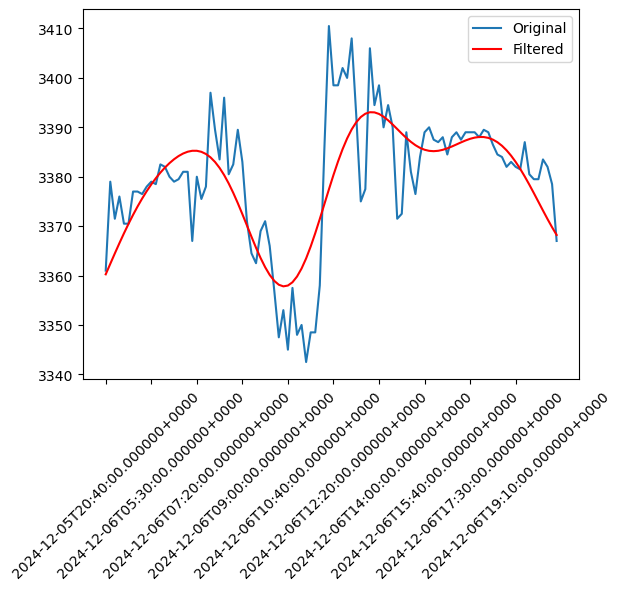

In [170]:
from scipy.signal import butter, filtfilt

data1 = data[-100:]
def butter_filter(data, cutoff_frequency, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 144
cutoff_frequency = 5
data_filtered = butter_filter(data1['open'].values, cutoff_frequency, fs)

plt.plot(data1['utc'], data1['open'], label='Original')
plt.plot(data1['utc'], data_filtered, label='Filtered', color='red')
plt.xticks(data1['utc'][::10], rotation=45)
plt.legend()
plt.show()

In [125]:
data['open_diff'] = (data['open'] - data['open'].shift()) / data['open'].shift()
data['high_diff'] = (data['high'] - data['high'].shift()) / data['high'].shift()
data['low_diff'] = (data['low'] - data['low'].shift()) / data['low'].shift()

numeric += ['open_diff', 'high_diff', 'low_diff']
normalize += ['open_diff','high_diff', 'low_diff']

In [126]:
data['date'] = pd.to_datetime(data['utc'])
data = data.drop(columns='utc')
data.dtypes

open                     float64
close                    float64
high                     float64
low                      float64
volume                     int64
open_div                 float64
close_div                float64
high_div                 float64
low_div                  float64
open_diff                float64
high_diff                float64
low_diff                 float64
date         datetime64[ns, UTC]
dtype: object

Добавляем целевую переменную $I [close_{t+1} > close_t]$

In [127]:
data['target'] = (data['close'].shift(-1) > data['close']).astype('int')
data

,open,close,high,low,volume,open_div,close_div,high_div,low_div,open_diff,high_diff,low_diff,date,target
0,2375.0,2379.5,2379.5,2375.0,231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-07 18:40:00+00:00,1
1,2380.0,2385.0,2385.0,2380.0,514,1.002105,1.002311,1.002311,1.002105,0.002105,0.002311,0.002105,2018-03-07 18:50:00+00:00,1
2,2385.5,2388.0,2388.0,2384.0,226,1.002311,1.001258,1.001258,1.001681,0.002311,0.001258,0.001681,2018-03-07 19:00:00+00:00,1
3,2388.0,2389.5,2389.5,2387.0,207,1.001048,1.000628,1.000628,1.001258,0.001048,0.000628,0.001258,2018-03-07 19:10:00+00:00,0
4,2386.5,2386.0,2389.0,2386.0,25,0.999372,0.998535,0.999791,0.999581,-0.000628,-0.000209,-0.000419,2018-03-07 19:20:00+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134444,3379.5,3384.0,3384.5,3379.5,741,1.000000,1.001183,1.001183,1.000592,0.000000,0.001183,0.000592,2024-12-06 20:00:00+00:00,0
134445,3383.5,3382.5,3383.5,3382.5,563,1.001184,0.999557,0.999705,1.000888,0.001184,-0.000295,0.000888,2024-12-06 20:10:00+00:00,0
134446,3382.0,3378.5,3382.0,3378.0,1449,0.999557,0.998817,0.999557,0.998670,-0.000443,-0.000443,-0.001330,2024-12-06 20:20:00+00:00,0
134447,3378.5,3366.5,3380.0,3351.0,8532,0.998965,0.996448,0.999409,0.992007,-0.001035,-0.000591,-0.007993,2024-12-06 20:30:00+00:00,1


**Признаки времени**

Праздники 🦎🥳🌷 (поиграться с периодом до праздника)

Ну хоть 2025 будет адекватным годом ... 😶

In [61]:
# data['is_holiday'] = data['date'].dt.strftime('%m-%d').isin(['12-31', '01-01', '01-07', '02-14', '02-23', '03-08', '05-01']).astype('int')
# data['pred_holiday'] = data['date'].dt.strftime('%m-%d').isin(['11-11', '11-30', '12-30', '02-13', '02-22', '03-07', '04-30']).astype('int') # + black friday
# data['week_pred_holiday'] = data['date'].dt.strftime('%m-%d').isin(['12-24', '02-07', '02-16', '03-01', '04-24']).astype('int')
# numeric += ['is_holiday', 'pred_holiday', 'week_pred_holiday']

День в недели

In [128]:
data['day_of_week'] = data['date'].dt.day_of_week

categoricals += ['day_of_week']

Время в сутках и сезон года

In [129]:
def get_season(x):
    if x < 3 or x == 12:
        return 1
    elif x < 6:
        return 2
    elif x < 9:
        return 3
    else:
        return 4

data['day_time'] = data['date'].dt.hour.where(data['date'].dt.hour > 12, 0)  # morning
data['day_time'] = data['day_time'].mask(data['day_time'] > 18, 2)  # evening
data['day_time'] = data['day_time'].mask(data['day_time'] > 2, 1) # afternoon


data['season'] = data['date'].dt.month.apply(lambda x: get_season(x))

categoricals += ['day_time', 'season']

**Признаки связанные с временным рядом**

Скользящее среднее

In [130]:
data['div'] = data['close'] - data['close'].shift(1)

data['avg_18'] = data['div'].rolling(window = 18, closed="left").mean()
data['avg_6'] = data['div'].rolling(window = 6, closed="left").mean()
data['avg_3'] = data['div'].rolling(window = 3, closed="left").mean()

numeric += ['avg_3', 'avg_6', 'avg_18']

EMA - экспонен. среднее `(вставить формулу)`

In [131]:
data['ema_3'] = data['div'].ewm(span=3).mean()
data['ema_6'] = data['div'].ewm(span=6).mean()
data['ema_18'] = data['div'].ewm(span=18).mean()
data['ema'] = data['div'].ewm(alpha=0.7).mean()

numeric += ['ema_3', 'ema_6', 'ema_18', 'ema']

Разности

In [132]:
data['rsi_3'] = data['close'] - data['close'].shift(3)
data['rsi_6'] = data['close'] - data['close'].shift(6)
data['rsi_18'] = data['close'] - data['close'].shift(18)

numeric += ['rsi_3', 'rsi_6', 'rsi_18']

Боллинджер и диспресия `formula`

In [133]:
data['SD'] =np.sqrt(np.square((data["avg_18"] - data["close"])).rolling(18, closed='left').sum())
data['upper_bollinger'] = data["avg_18"] + data['SD'] * 2
data['low_bollinger'] = data["avg_18"] - data['SD'] * 2

numeric += ['SD', 'low_bollinger', 'upper_bollinger']

High and low stuff

In [134]:
data['h_l'] = data['high'] - data['low']
data['h_l_18'] = data['high'].shift(18) - data['low'].shift(18)

data['h_l_vol'] = data['h_l'] * data['volume']

numeric += ['h_l', 'h_l_18', 'h_l_vol']

In [135]:
data['stochastic_oscillator'] = (data['close'] - data['low'].shift(18)) / (data['high'].shift(18) - data['low'].shift(18))
data['stochastic_oscillator_avg_3'] = data['stochastic_oscillator'].rolling(3).mean()

numeric += ['stochastic_oscillator', 'stochastic_oscillator_avg_3']

Something random 

In [136]:
data['target_predict'] = np.exp(np.log1p(data['close'].shift(15)) + 4 * np.random.normal(1)) - data['close']

numeric += ['target_predict']
normalize += ['target_predict']

In [81]:
# data['is_exam'] = data['date'].dt.strftime('%m-%d').isin(['12-11', '12-17', '12-24', '12-25']).astype('int')
# numeric += ['is_exam']

C:\Users\burko\AppData\Local\Temp\ipykernel_880\3753414333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_exam'] = data['date'].dt.strftime('%m-%d').isin(['12-11', '12-17', '12-24', '12-25']).astype('int')


In [137]:
numeric_norm = []
for feat in numeric:
    # norm = np.linalg.norm(data_notna[feat])
    # data_notna[feat + '_norm'] = data_notna[feat] - np.min(data_notna[feat]) / (np.max(data_notna[feat]) - np.min(data_notna[feat]))
    data[feat + '_norm'] = np.tanh(data[feat])
    numeric_norm.append(feat + "_norm")

**Итоги**

Корреляция

In [156]:
correlation_matrix = data[categoricals + numeric + ['target']].corr()
correlation_matrix['abs_corr'] = np.abs(correlation_matrix['target'])
correlation_matrix.sort_values(by = 'abs_corr', ascending = False)['target']

target                         1.000000
close_div                     -0.085096
ema                           -0.083760
ema_3                         -0.081701
ema_6                         -0.073050
rsi_3                         -0.061959
ema_18                        -0.052990
rsi_6                         -0.048640
low_diff                      -0.031580
low_div                       -0.031580
rsi_18                        -0.030365
high_div                      -0.029637
high_diff                     -0.029637
stochastic_oscillator         -0.029332
h_l                            0.017604
avg_3                         -0.016588
stochastic_oscillator_avg_3   -0.016294
avg_6                         -0.014006
open_div                      -0.013900
open_diff                     -0.013900
day_of_week                   -0.009592
avg_18                        -0.009299
h_l_18                         0.008435
target_predict                 0.005793
low_bollinger                 -0.005711


In [139]:
correlation_matrix = data_notna[categoricals + numeric_norm + ['target']].corr()
correlation_matrix['abs_corr'] = np.abs(correlation_matrix['target'])
correlation_matrix.sort_values(by = 'abs_corr', ascending = False)['target']

target                              1.000000
ema_3_norm                         -0.117297
ema_norm                           -0.116187
ema_6_norm                         -0.109006
close_div_norm                     -0.085921
rsi_3_norm                         -0.079122
ema_18_norm                        -0.078673
rsi_6_norm                         -0.064788
rsi_18_norm                        -0.051034
stochastic_oscillator_norm         -0.049816
low_diff_norm                      -0.030905
low_div_norm                       -0.030588
high_diff_norm                     -0.029416
high_div_norm                      -0.029339
stochastic_oscillator_avg_3_norm   -0.024859
avg_3_norm                         -0.019160
avg_6_norm                         -0.015128
open_div_norm                      -0.013600
open_diff_norm                     -0.013529
avg_18_norm                        -0.012405
day_of_week                        -0.009949
season                             -0.005174
h_l_norm  

Модель

In [141]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

other = []

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categoricals),
    ('scaling', StandardScaler(), numeric_norm),
    ('other',  'passthrough', other)
])

x_cols = categoricals + numeric_norm
# data_notna = data.dropna()
data_res = data[data.date.dt.date > datetime.strptime('01-09-2024', "%d-%m-%Y").date()]
x = data_res[x_cols]
print(x.columns)
x = column_transformer.fit_transform(x)

Index(['day_of_week', 'day_time', 'season', 'open_div_norm', 'close_div_norm',
       'high_div_norm', 'low_div_norm', 'volume_norm', 'open_diff_norm',
       'high_diff_norm', 'low_diff_norm', 'avg_3_norm', 'avg_6_norm',
       'avg_18_norm', 'ema_3_norm', 'ema_6_norm', 'ema_18_norm', 'ema_norm',
       'rsi_3_norm', 'rsi_6_norm', 'rsi_18_norm', 'SD_norm',
       'low_bollinger_norm', 'upper_bollinger_norm', 'h_l_norm', 'h_l_18_norm',
       'h_l_vol_norm', 'stochastic_oscillator_norm',
       'stochastic_oscillator_avg_3_norm', 'target_predict_norm'],
      dtype='object')


In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, data_res['target'], test_size=0.05, random_state=42)

# X_train = column_transformer.transform(X_train)
# X_test = column_transformer.transform(X_test)

Проверка констант

In [143]:
test_const = np.column_stack((X_test, y_test))
ones = np.sum(test_const[:, -1])
zeroes = test_const.shape[0] - ones
# consts = test_const.group_by(pl.col("direction_binary")).agg(pl.col("index").count())
# zeroes = consts.filter(pl.col("direction_binary") == 0)['index'].item()
# ones = consts.filter(pl.col("direction_binary") == 1)['index'].item()

print(f"Точность константного предсказания {zeroes/(ones + zeroes)}")

Точность константного предсказания 0.5313807531380753


In [144]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier(
    iterations=500, depth=5,use_best_model=True, loss_function='CrossEntropy', eval_metric='Accuracy', verbose=False)
model.fit(X_train, y_train, eval_set=Pool(X_test, y_test))
y_pred = model.predict(X_test)

In [93]:
y_test.shape

(478,)

In [94]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       254
           1       0.57      0.55      0.56       224

    accuracy                           0.60       478
   macro avg       0.59      0.59      0.59       478
weighted avg       0.60      0.60      0.60       478



In [84]:
feature_importance = model.get_feature_importance()
feature_names = categoricals+numeric
s = zip(feature_importance, feature_names)
s = sorted(s, key=lambda x: x[0], reverse=True)
# Display feature importance
for importance, name in s:
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: upper_bollinger, Importance: 32.96
Feature: high_div, Importance: 11.05
Feature: h_l, Importance: 10.51
Feature: h_l_vol, Importance: 9.94
Feature: low_div, Importance: 5.78
Feature: rsi_3, Importance: 3.16
Feature: ema_3, Importance: 3.14
Feature: target_predict, Importance: 2.36
Feature: low_bollinger, Importance: 2.35
Feature: ema_6, Importance: 2.20
Feature: h_l_18, Importance: 1.84
Feature: stochastic_oscillator_avg_3, Importance: 1.62
Feature: rsi_6, Importance: 1.25
Feature: stochastic_oscillator, Importance: 1.20
Feature: rsi_18, Importance: 1.01
Feature: avg_6, Importance: 0.93
Feature: avg_18, Importance: 0.92
Feature: SD, Importance: 0.54
Feature: open_div, Importance: 0.43
Feature: ema_18, Importance: 0.28
Feature: ema, Importance: 0.22
Feature: day_of_week, Importance: 0.00
Feature: day_time, Importance: 0.00
Feature: season, Importance: 0.00
Feature: close_div, Importance: 0.00
Feature: volume, Importance: 0.00
Feature: open_diff, Importance: 0.00
Feature: high_d